<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/combine_AandTnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (352, 1216), antialias = True)
    img = img / 255.0
    return img'''

'def load_image(img_path):\n    img = tf.io.read_file(img_path)\n    img = tf.io.decode_jpeg(img, channels = 3)\n    img = tf.image.resize(img, size = (352, 1216), antialias = True)\n    img = img / 255.0\n    return img'

In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [ ]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,0,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

In [ ]:
#batch_size = 16

class Unsuper_net(tf.keras.Model):
  def __init__(self):
    super(Unsuper_net,self).__init__()
    self.t_net=tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/t_net/')
    #self.a_net=build_model((352, 1216, 3))
    self.a_net=model1#tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/a_net/0.0271')

    for k,v in self.t_net._get_trainable_state().items():
      k.trainable = False

  def call(self,haze,gt=0,training=True):
    a1=self.a_net(haze)
    
    exp = tf.expand_dims(a1, axis=1)
    #print()
    a = tf.expand_dims(exp, axis=2)
    
    t=self.t_net(haze)
    #print(t.shape)
    #if training is True:
    #  
    #  j=gt
      #print(j.shape)
      #x=tf.keras.layers.Concatenate(axis=-1)([a,t,j])
    #  x=tf.add(tf.multiply(j,t),tf.multiply(a,(1-t)))
    #  return x
   
    #else:
   
    return  tf.add(tf.math.divide_no_nan(tf.add(haze,-(a)),t),a)   

  def model(self):
        x = Input(shape = (352, 1216, 3))
        #y = Input(shape = (352, 1216, 3))
        #return Model(inputs=[x,y], outputs=self.call(x,y))
        return Model(inputs=[x],outputs=self.call(x))
    
  def build_graph(self):
        x = Input(shape = (352, 1216, 3))
        #y = Input(shape = (352, 1216, 3))
        #return Model(inputs=[x,y], outputs=self.call(x,y))
        return Model(inputs=[x],outputs=self.call(x))



Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            26897657    input_9[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims_16 (TFOpLambda)  (None, 1, 1)         0           sequential_2[2][0]               
__________________________________________________________________________________________________
tf.expand_dims_17 (TFOpLambda)  (None, 1, 1, 1)      0           tf.expand_dims_16[0][0]          
___________________________________________________________________________________________

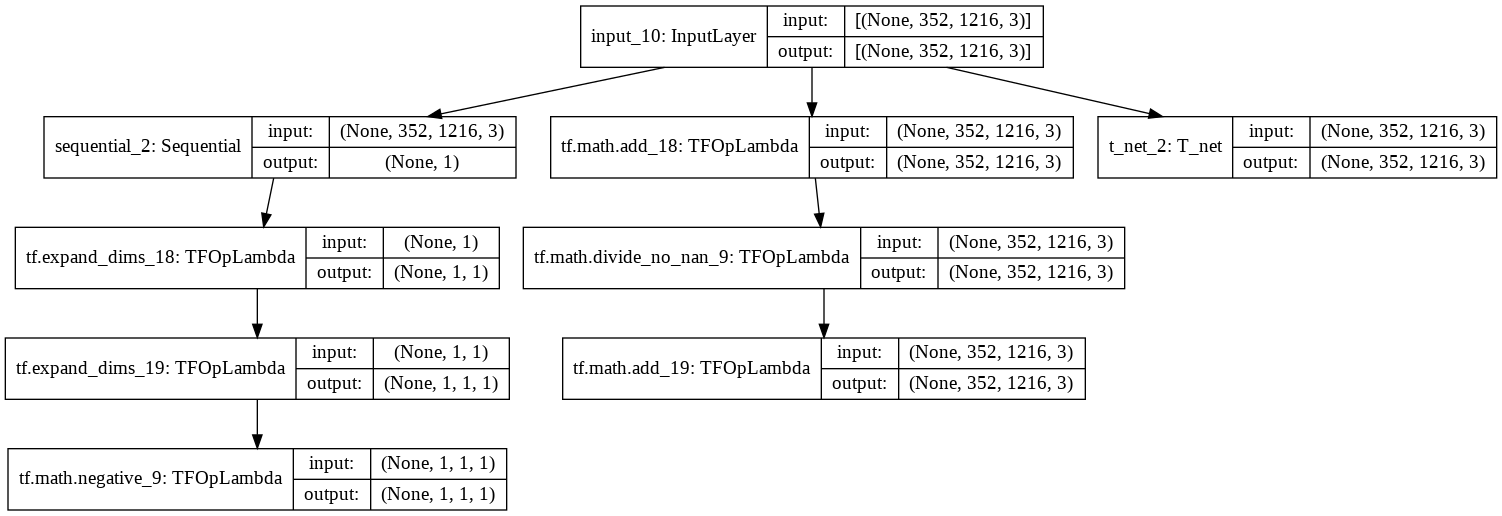

In [ ]:
model=Unsuper_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [ ]:
# Hyperparameters
epochs = 10

k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()
batch_size=1
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.05)
train, val = dataloader(train_data, val_data, batch_size)
net = Unsuper_net()
optimizer = Adam(learning_rate = 1e-5)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

270


In [ ]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze,train_batch_orig,training=True)
                loss = mean_squared_error(train_batch_haze,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze,0,False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [=====]  -  Training Loss: 0.0550

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


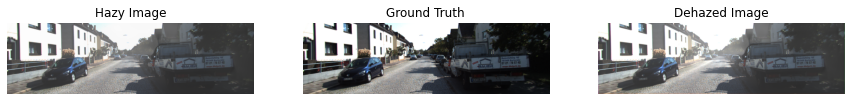

  -  Validation Loss: 0.0514  -   Time taken: 187.93s

Start of epoch 1 [=====]  -  Training Loss: 0.0554

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


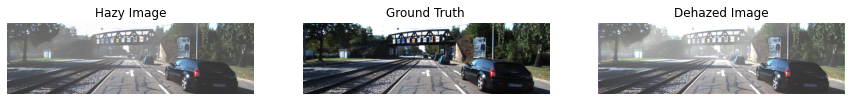

  -  Validation Loss: 0.0515  -   Time taken: 77.98s
CPU times: user 2min 29s, sys: 14.2 s, total: 2min 43s
Wall time: 4min 25s


In [ ]:
%%time
train_model(2, train, val,net,train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
net.save('/content/drive/MyDrive/nets/prelim_model/a_net/0.0271')
net.save_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/0.0271')